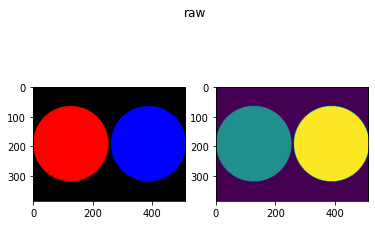

In [103]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

SCRIPT_DIR = str(Path(".").parent.resolve())
COLOR_IMAGE_PATH = f"{SCRIPT_DIR}/../data/color.png"
LABEL_IMAGE_PATH = f"{SCRIPT_DIR}/../data/label.png"

color_image = cv2.imread(COLOR_IMAGE_PATH)
label_image = cv2.imread(LABEL_IMAGE_PATH, cv2.IMREAD_ANYDEPTH)
n_classes = 3  # e.g. 0, 1, 2


def show_image(title: str, color_array: np.ndarray, with_colorbar=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.suptitle(title)
    im = ax.imshow(color_array)
    if with_colorbar:
        fig.colorbar(im)


def draw_labeled_image(title: str, color_array: np.ndarray, label_array: np.ndarray):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.imshow(color_array)
    ax2.imshow(label_array)


draw_labeled_image("raw", color_image, label_image)
plt.show()


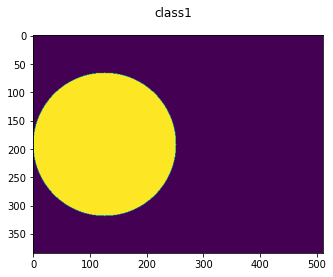

In [104]:
show_image("class1", label_image == 1)


In [105]:
def is_simplex_array(array: np.ndarray) -> bool:
    assert len(array.shape) == 3
    array_fp = array.astype(np.float32).sum(-1)
    I_2d = np.ones((array.shape[:-1]), dtype=np.float32)
    return np.allclose(array_fp, I_2d)


def np_issubset(a, b):
    return len(np.setdiff1d(a, b)) == 0


def is_one_hot(one_hot_array: np.ndarray) -> bool:
    sset_of_onehot = np_issubset(np.unique(one_hot_array), [0, 1])
    return is_simplex_array(one_hot_array) and sset_of_onehot


def class2one_hot(label_mask: np.ndarray, n_category: int) -> np.ndarray:
    assert len(label_mask.shape) == 2 and label_mask.dtype in [np.uint8, np.int16, np.int8, np.int16]
    return (np.arange(n_category) == label_mask[..., np.newaxis]).astype(np.int16)


one_hot_array = class2one_hot(label_image, n_category=n_classes)
is_one_hot(one_hot_array)

True

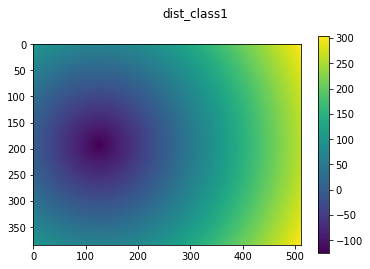

In [106]:
from scipy.ndimage import distance_transform_edt as eucl_distance

def one_hot2dist(one_hot_array: np.ndarray, n_category: int) -> np.ndarray:
    assert is_one_hot(one_hot_array)
    assert one_hot_array.shape[-1] == n_category
    res = np.zeros_like(one_hot_array).astype(np.float32)
    for c in range(n_category):
        posmask = one_hot_array[..., c].astype(bool)
        if posmask.any():
            negmask = ~posmask
            res[..., c] = eucl_distance(negmask) * negmask - (eucl_distance(posmask) - 1) * posmask
    return res

dist_image = one_hot2dist(one_hot_array, n_classes)
show_image("dist_class1", dist_image[:, :, 1], with_colorbar=True)

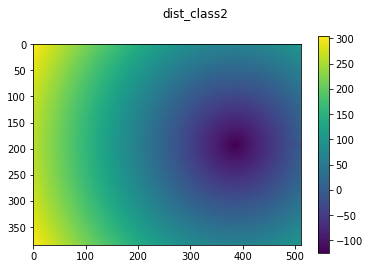

In [107]:
show_image("dist_class2", dist_image[:, :, 2], with_colorbar=True)

In [110]:
def calculate_boundary_loss(confidence_map: np.ndarray, distance_map: np.ndarray, n_category: int):
    assert is_simplex_array(confidence_map)
    assert confidence_map.shape == distance_map.shape
    assert confidence_map.shape[2] == n_category and distance_map.shape[2] == n_category

    confidence_map_fp = confidence_map.astype(np.float32)
    distance_map_fp = distance_map.astype(np.float32)
    multipled = np.einsum("whc,whc->whc", confidence_map_fp, distance_map_fp)
    loss = multipled.mean()
    return loss

calculate_boundary_loss(one_hot_array, dist_image, n_classes)

-13.246371